In [435]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
# display(Latex(f'$x_{i}$'))
def printL(code):
    display(Latex(f'${code}$'))

## function definitions

In [284]:
def poly_G(v):
    # Precompute common polynomial factor
    G = PF(1)
    for i in range(len(v)):
        G *= Y-v[i]
    return G

In [285]:
def poly_L(i,G,v):
    # Precompute Lagrangian polynomial
    L_i = G/(Y-v[i])
    denom = F(1)
    for h in range(len(v)):
        if h == i:
            continue
        denom *= v[i]-v[h]
    L_i /= denom
    return L_i

In [286]:
def sys_G_RS():
    # Compute a very systematic generator matrix
    eye = matrix.identity(F,k)
    G_RS = eye.augment(matrix.zero(F,nrows=k,ncols=n-k))
    G = poly_G(x[:k])
    #print(G)
    
    for i in range(k):
        L_i = poly_L(i,G,x[:k])
        G_RS[i,k:] = matrix(F,[L_i(x[j]) for j in range(k,n)])
    
    return G_RS

In [391]:
def RS_decoder(r):
    # r: received message
    # G_poly = poly_G(x)
    # L[i] = L_i = poly_L(i,G,x)
    # G_poly and L are precomputed globally
    
    R = r*L
    P = matrix(PF, [[G_poly,0],[-R,1]])
    
    while P[1,0].degree() >= (P[1,1].degree() + k - 1):
        (qP, rP) = P[0][0].quo_rem(P[1][0])
        P = matrix(PF, [ [P[1,0], P[1,1]], [rP, P[0,1] - qP*P[1,1]] ])
    
    if P[0,0].degree() < P[1,1].degree() + (k-1):
        f = -P[0,0]/P[0,1]
    else:
        f = -P[1,0]/P[1,1]
        
    return vector(F,[f(x[i]) for i in range(n)])


In [288]:
def sim_chan(p,c):
    # p: cross-over probability
    # c: codeword sent through channel
    # r: received codeword
    # alpha: correct letter
    # beta: wrong letter
    # alphabet: global variable that contains F.list()
    
    r = vector(F,n)
    for i in range(n):
        if random.random() > p:
            r[i] = c[i]
        else:
            beta_idx = (alphabet.index(c[i]) + random.randint(1,q-1)) % q
            r[i] = alphabet[beta_idx]
    return r

In [289]:
def random_msg():
    return vector([F.random_element() for i in range(k)])

## Simulations of decoding error rate

In [403]:
# Precomputing
q = 256; n = 255; k = 251
F.<X> = FiniteField(q)
PF.<Y> = PolynomialRing(F)
alphabet = F.list()
x = alphabet[1:]

G = sys_G_RS()

G_poly = poly_G(x)
L = vector(PF,[poly_L(i,G_poly,x) for i in range(n)])

#parity check matrix:
A = G[:,k:]
B = -A.transpose()
H = B.augment(matrix.identity(F,n-k))


In [423]:
# probability simulation
def simulate_failure_rate(p,N):
    failures = 0
    errors = 0
    for i in range(N):
        m = random_msg()
        c = m*G
        r = sim_chan(p,c)
        c_hat = RS_decoder(r)
        if c_hat != c:
            failures += 1
            if H*c_hat == vector(F,n-k):
                errors += 1
                
        if (i+1) % 100 == 0:
            print(f"{100*(i+1)/N}% : {failures}, {errors}")
            
    print(f"Number of failures: {failures}")
    print(f"Number of errors: {errors}")
    print(f"Failure rate: {failures/N}")
    print(f"Error rate: {errors/N}")
    return (p,N,failures,errors)

In [174]:
test1 = simulate_failure_rate(0.001,1000)

10% : 0, 0
20% : 0, 0
30% : 0, 0
40% : 1, 1
50% : 1, 1
60% : 1, 1
70% : 1, 1
80% : 3, 1
90% : 4, 2
100% : 4, 2
Number of failures: 4
Number of errors: 2
Failure rate: 1/250
Error rate: 1/500


In [176]:
test2 = simulate_failure_rate(0.001,1000)

10% : 0, 0
20% : 0, 0
30% : 2, 0
40% : 3, 0
50% : 3, 0
60% : 3, 0
70% : 3, 0
80% : 3, 0
90% : 3, 0
100% : 3, 0
Number of failures: 3
Number of errors: 0
Failure rate: 3/1000
Error rate: 0


In [177]:
test3 = simulate_failure_rate(0.001,1000)

10% : 0, 0
20% : 0, 0
30% : 1, 0
40% : 1, 0
50% : 1, 0
60% : 1, 0
70% : 1, 0
80% : 2, 1
90% : 2, 1
100% : 2, 1
Number of failures: 2
Number of errors: 1
Failure rate: 1/500
Error rate: 1/1000


In [178]:
test4 = simulate_failure_rate(0.001,1000)

10% : 0, 0
20% : 0, 0
30% : 0, 0
40% : 0, 0
50% : 0, 0
60% : 0, 0
70% : 0, 0
80% : 0, 0
90% : 0, 0
100% : 0, 0
Number of failures: 0
Number of errors: 0
Failure rate: 0
Error rate: 0


In [425]:
test5 = simulate_failure_rate(0.001,1000)

10% : 0, 0
20% : 0, 0
30% : 2, 1
40% : 2, 1
50% : 2, 1
60% : 2, 1
70% : 2, 1
80% : 2, 1
90% : 2, 1
100% : 2, 1
Number of failures: 2
Number of errors: 1
Failure rate: 1/500
Error rate: 1/1000


### Decoding with x errors

In [381]:
def add_x_errors(x,c):
    indexes = random.sample(range(k),x)
    c_err = vector(F,n)
    for i in range(n):
        if i in indexes:
            primitive_power = (alphabet.index(c[i]) + random.randint(1,q-1)) % q
            c_err[i] = alphabet[primitive_power]
        else:
            c_err[i] = c[i]
    return c_err

In [427]:
def simulate_decoding_x_errors(x,N):
    failures = 0
    errors = 0
    for i in range(N):
        m = random_msg()
        c = m*G
        r = add_x_errors(x,c)
        c_hat = RS_decoder(r)
        if c_hat != c:
            failures += 1
            if H*c_hat == vector(F,n-k):
                errors += 1
        if (i+1) % 100 == 0:
            print(f"{100*(i+1)/N}% : {failures}, {errors}")
    print(f"Simulated channel errors: {x}")
    print(f"Number of failures: {failures}")
    print(f"Number of errors: {errors}")
    print(f"Failure rate: {failures/N}")
    print(f"Error rate: {errors/N}")
    return (x,N,failures,errors)

In [429]:
simulations = [simulate_decoding_x_errors(x,100) for x in range(5)]

100% : 0, 0
Simulated channel errors: 0
Number of failures: 0
Number of errors: 0
Failure rate: 0
Error rate: 0
100% : 0, 0
Simulated channel errors: 1
Number of failures: 0
Number of errors: 0
Failure rate: 0
Error rate: 0
100% : 0, 0
Simulated channel errors: 2
Number of failures: 0
Number of errors: 0
Failure rate: 0
Error rate: 0
100% : 100, 54
Simulated channel errors: 3
Number of failures: 100
Number of errors: 54
Failure rate: 1
Error rate: 27/50
100% : 100, 49
Simulated channel errors: 4
Number of failures: 100
Number of errors: 49
Failure rate: 1
Error rate: 49/100


In [432]:
plot_data = matrix(simulations)
plot_data

[  0 100   0   0]
[  1 100   0   0]
[  2 100   0   0]
[  3 100 100  54]
[  4 100 100  49]

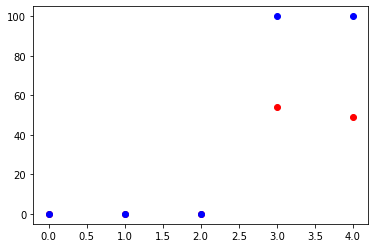

In [436]:
xdata = plot_data[:,0]
ydata1 = plot_data[:,2]
ydata2 = plot_data[:,3]
plt.scatter(xdata, ydata2, color = 'r')
plt.scatter(xdata, ydata1, color = 'b')